# Device hamiltonian and parameters
Remeber the hamiltonian of a DWave quantum anneler

$$ \mathcal{H}_{\text{ising}} = - \frac{A(s)}{2} \left( \sum_i \hat{\sigma}_x^{(i)} \right) + \frac{B(s)}{2} \left( \sum_i h_i \hat{\sigma}_z^{(i)} + \sum_{i>j} J_{i,j} \hat{\sigma}_z^{(i)} \hat{\sigma}_z^{(j)} \right) $$

where $A(s), B(s)$ depends on the device, while $h_i, J_{i,j}$ are defined from the user.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import random
import pickle
from matplotlib import pyplot as plt
from settings import DATA_DIR, ANNEALING_SCHEDULE_XLS

# loading annealing functions
df = pd.read_excel(ANNEALING_SCHEDULE_XLS, sheet_name=1)
nominal_temp_ghz = 13.5 / 47.9924341590788

In [2]:
df.head()

,s,A(s) (GHz),B(s) (GHz),C (normalized)
0,0.000000,9.965879,0.062970,0.000000
1,0.001001,9.909568,0.064592,0.003373
2,0.002002,9.854917,0.066236,0.006623
3,0.003003,9.800594,0.067900,0.009849
4,0.004004,9.746270,0.069585,0.013074


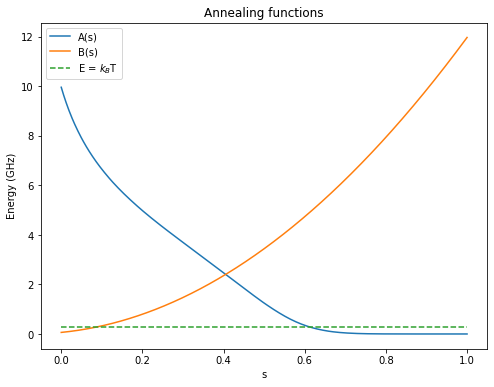

In [3]:
# plot annealing functions vs annealing parameter and plotting nominal temperature for comparison
plt.figure(figsize=(8, 6))
plt.plot(df['s'], df['A(s) (GHz)'], label='A(s)')
plt.plot(df['s'], df['B(s) (GHz)'], label='B(s)')
plt.plot(np.linspace(0,1), nominal_temp_ghz * np.ones(50), linestyle='--', label='E = $k_B$T')

plt.title('Annealing functions')
plt.xlabel('s')
plt.ylabel('Energy (GHz)')
plt.legend()
plt.show()

# Single qubit temperature measurements
Reducing ourselves to a single spin, we have the freedom to choose *h* and the annealing parameter *s(t)*.

$$ \quad \forall i,j \quad J_{i,j}=0 $$

$$ \mathcal{H}_{\text{single qubit}} = - \frac{A(s)}{2} \hat{\sigma}_x + \frac{B(s)}{2} h \hat{\sigma}_z $$

Minimun energy gap for h=0.5: 2.110 GHz
Minimun energy gap for h=0.01: 0.070 GHz
Nominal thermal energy: 0.281 GHz


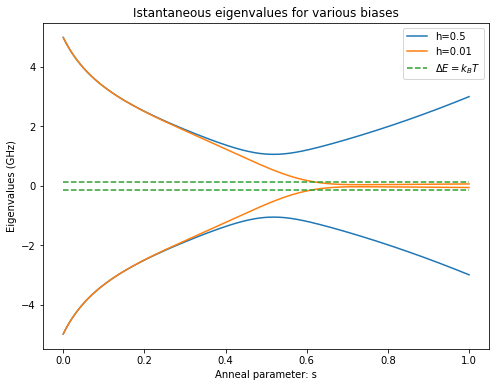

In [4]:
# plot hamiltonian istantanous eigenvalues vs annealing parameters for various h
biases = [0.5, 0.01]
colors = ['C0', 'C1']

sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.diag([1, -1])

plt.figure(figsize=(8, 6))
plt.title(f'Istantaneous eigenvalues for various biases')

for h, c in zip(biases, colors):
    # H is a list of matrices, eigenvals is a list of couple of eigenvalues
    H = [a / 2 * sigma_x + b / 2 * h * sigma_z for a, b in zip(df['A(s) (GHz)'], df['B(s) (GHz)'])]
    eigenvals = [np.linalg.eigvalsh(hamilt) for hamilt in H]

    anneal_parameter = np.linspace(0, 1, len(eigenvals))
    negative_eigenvals, positive_eigenvals = np.array(eigenvals).T
    print(f'Minimun energy gap for h={h}: {np.min(positive_eigenvals - negative_eigenvals):.3f} GHz')

    # plot the figure
    plt.plot(anneal_parameter, negative_eigenvals, c=c, label=f'h={h}')
    plt.plot(anneal_parameter, positive_eigenvals, c=c)

print(f'Nominal thermal energy: {nominal_temp_ghz:.3f} GHz')
plt.plot(np.linspace(0, 1), nominal_temp_ghz * np.ones(50) / 2, c='C2', linestyle='--', label='$\Delta E=k_B T$')
plt.plot(np.linspace(0, 1), - nominal_temp_ghz * np.ones(50) / 2, c='C2', linestyle='--')

plt.xlabel('Anneal parameter: s')
plt.ylabel('Eigenvalues (GHz)')
plt.legend()
plt.show()

In [5]:
# cerco quali device sono disponibili al momento
from dwave.cloud import Client

with Client.from_config() as client:
    for solver in client.get_solvers():
        print(solver.id)

DW_2000Q_6
Advantage_system1.1
hybrid_binary_quadratic_model_version2
hybrid_discrete_quadratic_model_version1


In [6]:
# I choose the device and make sure I can communicate with it, I print some features on the screen
from dwave.system import DWaveSampler
import dwave.inspector

sampler = DWaveSampler(solver='DW_2000Q_6')

print(f'Maximum anneal-schedule points: {sampler.properties["max_anneal_schedule_points"]}')
print(f'Annealing time range: {sampler.properties["annealing_time_range"]} \u03BCs')
print(f'Maximum slope allowed on this solver is {1.0/sampler.properties["annealing_time_range"][0]}')

# sampler.parameters

Maximum anneal-schedule points: 12
Annealing time range: [1, 2000] μs
Maximum slope allowed on this solver is 1.0


## Classical approach: trivial reverse annealing

First, I initialize my state directly into an eigenstate of $\hat \sigma_z$ using reverse annealing. I initialize the state in the first excited and do not modify the annealing parameter. I wait for the maximum time compatible with the machine and measure the long state $\hat \sigma_z$.

In [7]:
# parameters
annealing_time = 2000
h1 = 0.05
# for h = 0.028, energy gap along z between ground and the first excited level should be equal to thermal energy

trivial_reverse_schedule = [[0.0, 1.0], [annealing_time, 1.0]]
linear_offsets = {active_node: h1 * random.choice([-1, 1]) for active_node in sampler.nodelist}
initial_state = {active_node: np.sign(linear_offsets[active_node]) for active_node in linear_offsets}

In [8]:
# RUN 'thermal' evolution of excited sigma_z eigenstate

sampler.validate_anneal_schedule(trivial_reverse_schedule)
# sampleset = sampler.sample_ising(linear_offsets, {}, num_reads=10, auto_scale=False, anneal_schedule=trivial_reverse_schedule, initial_state=initial_state, label=f'Trivial reverse annealing test h={h}')

# save data to file
# pickle.dump((linear_offsets, sampleset), open(DATA_DIR / "trivial_reverse_annealing_h" + str(h1) + ".pickle", "wb"))

In [9]:
linear_offsets, sampleset = pickle.load(open(DATA_DIR / f"trivial_reverse_annealing_h{h1}.pickle", "rb"))
sampleset.aggregate().to_pandas_dataframe()

,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,energy,num_occurrences
0,1,-1,1,1,-1,1,1,-1,1,-1,...,1,-1,1,-1,1,-1,1,-1,102.05,10


In [10]:
# recall some parameters of the simulation
num_qubits_per_run = len(sampleset.record["sample"][0])
final_B = df['B(s) (GHz)'].to_numpy()[-1]
anneling_times = np.array(trivial_reverse_schedule).T[0]

# I define the initial energy to which I initialized the state and the final energy after the temporal evolution (GHz)
initial_energy = final_B * h1
final_energy = final_B * np.sum(sampleset.record['energy'] * sampleset.record['num_occurrences']) / np.sum(sampleset.record['num_occurrences']) / num_qubits_per_run

print(f'Initial state energy for {num_qubits_per_run} qubits: {h1 * num_qubits_per_run:.2f}')

Initial state energy for 2041 qubits: 102.05


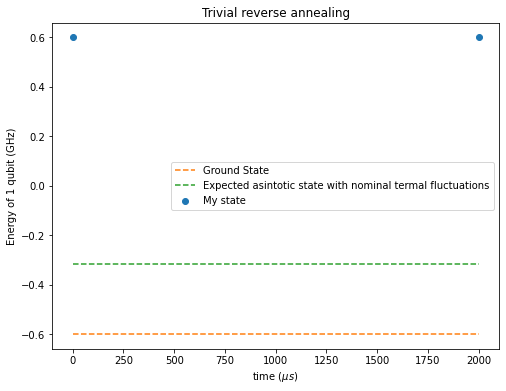

In [11]:
# plot the state evolution
plt.figure(figsize=(8, 6))
plt.scatter(anneling_times, np.array([initial_energy, final_energy]), label='My state')
plt.plot(anneling_times, np.array([-initial_energy, -initial_energy]), linestyle='--', color='C1', label='Ground State')
plt.plot(anneling_times, np.array([-initial_energy + nominal_temp_ghz, -initial_energy + nominal_temp_ghz]), linestyle='--', color='C2', label='Expected asintotic state with nominal termal fluctuations')

plt.title('Trivial reverse annealing')
plt.xlabel('time ($\mu s$)')
plt.ylabel(f'Energy of 1 qubit (GHz)')
plt.legend()
plt.show()

The (classical) dynamics of evolution is too slow with respect to $t_f$, therefore we cannot see the termalization.

## Boltzmann distribution

Naively, one might expect the final distribution at the end of the anneal to be a classical Boltzmann distribution
for the problem Hamiltonian H at the operating temperature of the device, specifically,

$$\rho \sim \exp (- \beta B(1) h \hat{\sigma}_z / 2), \qquad \text{where} \quad \beta = 1/k_B T,$$

with T the operating temperature of the annealer (on the order of $10-20mK$). But it has long been known that is not the case.

Reference: *Power of Pausing, Venturelli*  [arXiv:1810.05881](https://arxiv.org/abs/1810.05881)

The freezout hypothesis suggests that state dynamics stops when the time scale of evolution, governed by A(s) becomes greater than $t_f$. The equality of times is called ** freezout point **.

The final distribution of states will be similar to $$\rho \sim \exp (- \beta B(s^*) h \hat{\sigma}_z / 2), $$ where $s^*$ is the freezout point of the system.

The expected distribution of spin up population is

$$P_↑/(1-P_↑)=\exp(-\delta E / k_B T) \qquad \text{con} \quad \delta E = h \times B(s^*) $$

### Find T assuming s*= 0.719

###### Using just a single spin

In [12]:
# single spin example
h = {4: 0.01}
J = {}

# RUN samples
# sampleset = sampler.sample_ising(h, J, num_reads=20, auto_scale=False, label='Autoscale False')

# save data to file
# pickle.dump(sampleset, open(DATA_DIR / "boltz_single_spin.pickle", "wb"))

In [13]:
# print and view results
# print(sampleset)
# dwave.inspector.show(sampleset)

In [14]:
# load data from pickle example
loaded_data = pickle.load(open(DATA_DIR / "boltz_single_spin.pickle", "rb"))
print(loaded_data)

   0 energy num_oc.
0 -1  -0.01       9
1 +1   0.01      11
['SPIN', 2 rows, 20 samples, 1 variables]


###### Using all spins indipendently

In [15]:
# setting run parameters
N = 20
biases = np.linspace(-0.3, 0.3, N)

In [16]:
# RUN different energy gap samples for all active spins in machine
for i, h in enumerate(biases):
    linear_offsets = {active_node: h * random.choice([-1, 1]) for active_node in sampler.nodelist}
    # sampleset = sampler.sample_ising(linear_offsets, {}, num_reads = 10, auto_scale=False, label=f'Boltzmann h={h}')
    
    # save data to file
    # pickle.dump((h, sampleset), open(DATA_DIR / f"boltzmann{i}.pickle", "wb"))

In [17]:
def spin_up_pop(record, h):
    # calcoliamo la percentuale di popolamento dello stato con spin positivo lungo z
    if h == 0:
        return 0.5
    num_spins = len(record['sample'][0])
    all_spin_up_energy = - h * num_spins
    ensamble_energy = np.sum(record.num_occurrences * (record.energy - all_spin_up_energy) / record.num_occurrences.sum())
    
    n_spin_down = ensamble_energy / 2 / h / num_spins
    n_std = 1 / np.sqrt(4 * num_spins * record.num_occurrences.sum())
    
    return 1 - n_spin_down, n_std

In [18]:
# load data from file
n_spin_up = []
dn_spin_up = []
biases = []

for i in range(N):
    h, loaded_sampleset = pickle.load(open(DATA_DIR / f"boltzmann{i}.pickle", "rb"))
    spin_up, dspin_up = spin_up_pop(loaded_sampleset.record, h)
    
    biases.append(h)
    n_spin_up.append(spin_up)
    dn_spin_up.append(dspin_up)
    
biases = np.array(biases)
n_spin_up = np.array(n_spin_up)
dn_spin_up = np.array(dn_spin_up)

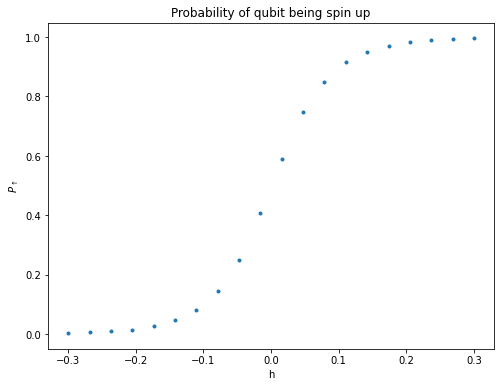

In [19]:
# ground state population vs h graph
plt.figure(figsize=(8,6))
plt.errorbar(biases, n_spin_up, dn_spin_up, marker='.', linestyle='')
plt.title('Probability of qubit being spin up')
plt.xlabel('h')
plt.ylabel(r'$P_\uparrow$')
plt.show()

In [20]:
from scipy.optimize import curve_fit

def temperature_fit_function(x, T):
    return 1 / (1 + np.exp(- x / T))

In [21]:
# defining s star and finding the corresponding value for B
s_star = 0.719
closest_s = df.iloc[(df['s'] - s_star).abs().argsort()[0]]

$$ \frac{P_\uparrow}{1-P_\uparrow}=\exp \left( \frac{-B(s^*)h}{2 k_B T} \right) $$

<!-- $$ P_\uparrow = \frac{\exp \left( \frac{-B(s^*)h}{2 k_B T} \right)}{1 + \exp \left( \frac{-B(s^*)h}{2 k_B T} \right)} $$ -->

$$ P_\uparrow = \left[ 1 + \exp \left( \frac{B(s^*)h}{2 k_B T} \right) \right] ^{-1} $$

In [22]:
# fit the curve to find the temperature
popt, pcov = curve_fit(temperature_fit_function, closest_s['B(s) (GHz)'] * biases, n_spin_up, sigma = dn_spin_up, absolute_sigma=True)

# compute the mean and the chi^2/dof
z = (n_spin_up - temperature_fit_function(closest_s['B(s) (GHz)'] * biases, popt[0])) / dn_spin_up
chi2 = np.sum(z ** 2)
chi2dof = chi2 / (N - 1)
sigma = np.sqrt(2. / (N - 1))
nsig = (chi2dof - 1) / sigma
    
ghz_to_mk = 0.0479924341590788 * 1000

print('The single qubit temperature results equal to {0:.4f} +/- {1:.4f} GHz'.format( popt[0], np.sqrt(pcov[0][0]) ))
print('Equivalently {0:.2f} +/- {1:.2f} mK'.format( popt[0] * ghz_to_mk, np.sqrt(pcov[0][0]) * ghz_to_mk))

chi2dof

The single qubit temperature results equal to 0.2968 +/- 0.0013 GHz
Equivalently 14.24 +/- 0.06 mK


4.898428529297493

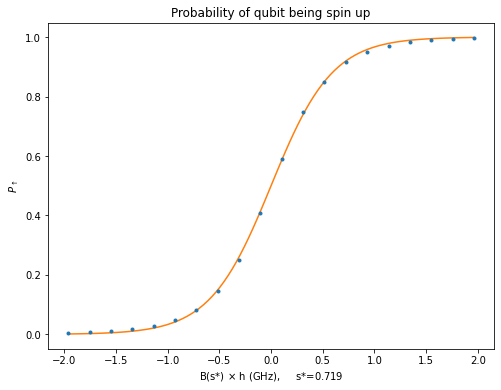

In [23]:
# replot, with B on the x-axis
xx = np.linspace(min(closest_s['B(s) (GHz)'] * biases), max(closest_s['B(s) (GHz)'] * biases), 100)

plt.figure(figsize=(8,6))
plt.errorbar(closest_s['B(s) (GHz)'] * biases, n_spin_up, dn_spin_up, marker='.', linestyle='')
plt.plot(xx, temperature_fit_function(xx, popt))
plt.title('Probability of qubit being spin up')
plt.xlabel(r'B(s*) $\times$ h (GHz), $\quad$ s*=' + str(s_star))
plt.ylabel(r'$P_\uparrow$')
plt.show()

### Find s*

If interested in following this path, we can experimentally determine s*, without taking it from the official docs.

## Initial quench and pause

The idea is that by doing a fast qubit qubit, it goes into the high energy state more often because it is driven by the *kinetic energy* of the annealing, compared to the distribution I would have going slowly (influenced only by the thermal bath).

Waiting enough time, the state evolves towards a situation of equilibrium and by sampling this evolution I can describe the thermalization process.

I did not complete this part of the simulation, given the results of **trivial reverse annealing**.

I left the code for *future reference* for experiments with *quench schedule*

In [24]:
# parameters
t_quench = 2.0
t_f = 20.0
h0 = 0.0001
# for h = 0.025, the energy along z should be equal to the thermal energy

quench_schedule = [[0.0, 0.0], [t_quench, 1.0], [t_f, 1.0]]
linear_offsets = {active_node: h0 if active_node % 2 == 0 else -h0 for active_node in sampler.nodelist}

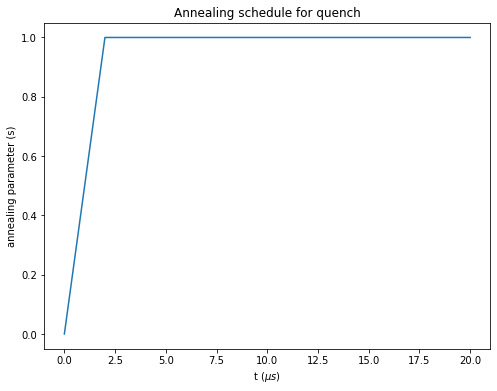

In [25]:
# show anneal schedule
plt.figure(figsize=(8, 6))
plt.plot(*np.array(quench_schedule).T)

plt.title('Annealing schedule for quench')
plt.xlabel('t ($\mu s$)')
plt.ylabel('annealing parameter (s)')
plt.show()

Tuttavia dopo il quench, la dinamica del qubit, governata da $A(s)$, evolve con tempi scala $t>>t_f=200\mu s$

Di conseguenza mi aspetto di non riuscire a vedere la termalizzazione

In [26]:
# sampling the system after quench
sampler.validate_anneal_schedule(quench_schedule)
# sampleset0 = sampler.sample_ising(linear_offsets, {}, num_reads=10, anneal_schedule=quench_schedule, label=f'Quench test h={h}')
# print(sampleset0)

In [27]:
def print_risultati(sampleset, linear_offsets, h):
    # how many different results we found
    print(f'Ho ottenuto {len(sampleset.record)} risultato(i) diverso(i).')
    
    # for each result we print if it is the global minimum or not
    for ii in range(len(sampleset.record)):
        results = sampleset.record[ii].sample
        biases = np.array(list(linear_offsets.values()))
        if np.all(np.sign(results) != np.sign(biases)):
            print(f"Tutti gli spin sono nel minimo dell'energia, per h={h}.")
        elif np.all(np.sign(results) == np.sign(biases)):
            print(f"Tutti gli spin sono nel massimo dell'energia, per h={h}.")
        else:
            print("Ho almeno uno spin NON nel minimo/massimo.")

In [28]:
# print_risultati(sampleset0, linear_offsets, h0)

# Entanglement creation

Cerchiamo un modo per creare un Bell state nel nostro sistema
$$\newcommand{\ket}[1]{|#1\rangle}$$
$$ \ket{\Phi^+} = \frac{\ket{00}_A + \ket{11}_B}{\sqrt{2}} $$

Consideriamo l'hamiltoniana (di 2 qubits) con $h_i = 0$:

$$ \mathcal{H}_2 = - \frac{A(s)}{2} \left( \hat{\sigma}^x_A + \hat{\sigma}^x_B \right) + \frac{B(s)}{2} J \hat{\sigma}^z_A\hat{\sigma}^z_B $$

In [29]:
# Fix the parameters
J = - 1
s = [0, 0.5, 1]

In [30]:
# compute the hamiltonians for various s
hamiltonians = []

for s_star in s:
    closest_s = df.iloc[(df['s'] - s_star).abs().argsort()[0]]
    A = closest_s['A(s) (GHz)']
    B = closest_s['B(s) (GHz)']

    identity = np.diag([1, 1])
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_z = np.diag([1, -1])

    hamilt = - A / 2 * (np.tensordot(sigma_x, identity, axes=0) + np.tensordot(identity, sigma_x, axes=0)) + B / 2 * J * np.tensordot(sigma_z, sigma_z, axes=0)

    # reshape hamit in 2D
    row0 = np.concatenate((hamilt[0,0,0], hamilt[0,1,0]))
    row1 = np.concatenate((hamilt[0,0,1], hamilt[0,1,1]))
    row2 = np.concatenate((hamilt[1,0,0], hamilt[1,1,0]))
    row3 = np.concatenate((hamilt[1,0,1], hamilt[1,1,1]))

    reshaped_hamilt = np.concatenate((row0, row1, row2, row3)).reshape(4, 4)
    hamiltonians.append(reshaped_hamilt)
    
print(f'Hamiltonian for s={s_star}:\n', reshaped_hamilt)

Hamiltonian for s=1:
 [[-5.988590e+00 -9.519025e-08 -9.519025e-08 -0.000000e+00]
 [-9.519025e-08  5.988590e+00 -0.000000e+00 -9.519025e-08]
 [-9.519025e-08 -0.000000e+00  5.988590e+00 -9.519025e-08]
 [-0.000000e+00 -9.519025e-08 -9.519025e-08 -5.988590e+00]]


In [31]:
# calcolo ground, primo eccitato e gap energetico per le varie s
energy_gaps = []
ground_states = []
first_excited_states = []

for hamilt in hamiltonians:
    v, w = np.linalg.eigh(hamilt)
    energy_gaps.append(v[1] - v[0])
    ground_states.append(w[:,0])
    first_excited_states.append(w[:,1])

print(f'Some results for s={s_star}')
print(f'Energy gap: {energy_gaps[-1]:.3f} GHz')
print(f'Termal energy: {nominal_temp_ghz:.3f} GHz')
print('Ground state vector:', ground_states[-1])
first_excited_states[-1]

Some results for s=1
Energy gap: 0.000 GHz
Termal energy: 0.281 GHz
Ground state vector: [8.76807158e-01 1.07901009e-08 1.07901009e-08 4.80842187e-01]


array([ 4.80842187e-01, -3.14698490e-09, -3.14698490e-09, -8.76807158e-01])

Il ground state per $A=B|J|$ risulta essere
$$\newcommand{\ket}[1]{|#1\rangle}$$
$$ \ket{ground} = 0.60 \times \ket{\Phi^+} + 0.37 \times \ket{\Psi^+} $$

In [32]:
def create_composite_state(i, j):
    # returns a vector of the form (1-i, i, 1-j, j) correctly normalised
    def create_single_normalised_array(k):
        return np.array([1-k, k]) / np.sqrt((1-k)**2 + k**2)
    
    psi_A = create_single_normalised_array(i)
    psi_B = create_single_normalised_array(j)

    psi = np.empty(4)
    psi[0] = psi_A[0] * psi_B[0]
    psi[1] = psi_A[1] * psi_B[0]
    psi[2] = psi_A[0] * psi_B[1]
    psi[3] = psi_A[1] * psi_B[1]
    
    return psi

Ground state probability 1.000
Ground state probability 0.810
Ground state probability 0.500


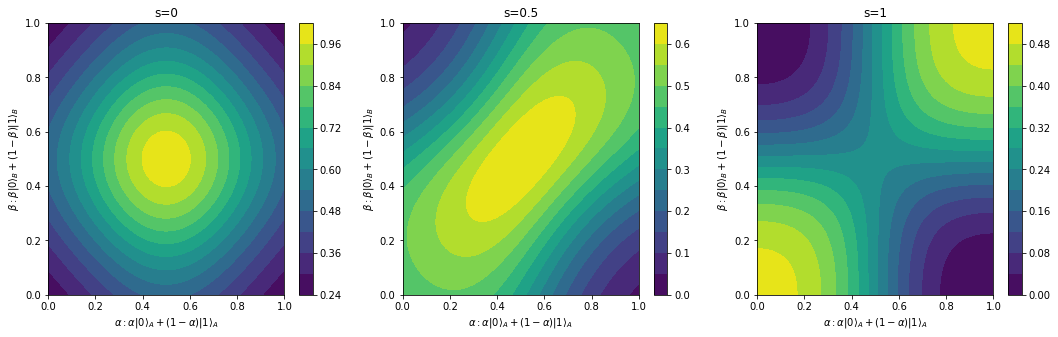

In [33]:
from matplotlib.colors import BoundaryNorm, LogNorm
from matplotlib.ticker import MaxNLocator

N = 100
fig, axs = plt.subplots(1, len(s), figsize=(18, 5))

x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
z = np.empty((N, N))

for k in range(len(s)):
    p_ground = 1 / (1 + np.exp(- energy_gaps[k] / nominal_temp_ghz))
    print(f'Ground state probability {p_ground:.3f}')
    for ii in range(N):
        for jj in range(N):
            ground_mod2 = np.dot(create_composite_state(x[ii], y[jj]), ground_states[k]) ** 2
            first_excit_mod2 = np.dot(create_composite_state(x[ii], y[jj]), first_excited_states[k]) ** 2
            
            z[ii,jj] = ground_mod2 * p_ground + first_excit_mod2 * (1-p_ground)

    levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())
    color = axs[k].contourf(x, y, z, levels=levels)
    plt.colorbar(color, ax=axs[k])
    axs[k].set_xlabel(r'$\alpha: \alpha |0\rangle_A + (1-\alpha) |1\rangle_A$')
    axs[k].set_ylabel(r'$\beta: \beta |0\rangle_B + (1-\beta) |1\rangle_B$')
    axs[k].set_title(f's={s[k]}')